In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, euclidean_distances

import torch.nn as nn
from torch_geometric.nn.conv import *
from torch.optim import Adam
import torch

import h5py

import scipy.stats as stats
import pylab

torch.set_default_dtype(torch.float64)

In [2]:
phi = (1 + np.sqrt(5)) / 2
icosahedron = []

for k in range(3):
    
    for i in range(2):
        for j in range(2):
            if k == 0:
                t = (0, (-1)**j, phi * (-1)**i)
                icosahedron.append(t)

            elif k == 1:
                t = ((-1)**j, phi * (-1)**i, 0)
                icosahedron.append(t)

            elif k == 2:
                t = (phi * (-1)**i, 0, (-1)**j)
                icosahedron.append(t)

icosahedron = np.stack(icosahedron)
icosahedron /= np.linalg.norm(icosahedron, axis = 1)[0]

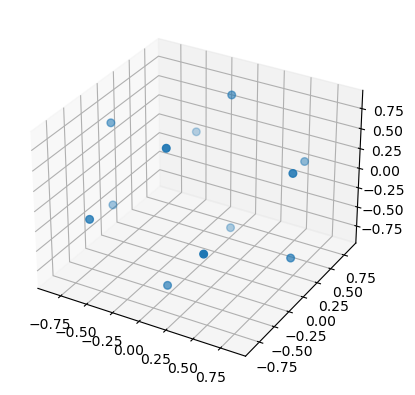

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(icosahedron[:,0], icosahedron[:,1], icosahedron[:,2], s = 30)

In [4]:
edges = np.nonzero((pairwise_distances(icosahedron) < 1.06)) # & (pairwise_distances(icosahedron) > 0.06)

In [5]:
level1 = 0.5 * icosahedron[edges[0]] + 0.5 * icosahedron[edges[1]]
level1 /= np.linalg.norm(level1, axis = 1).reshape(-1, 1)
level1 = np.unique(level1, axis = 0) 

In [6]:
level1.shape

(42, 3)

In [7]:
edges2 = np.nonzero(pairwise_distances(level1) < 0.7)

level2 = 0.5 * level1[edges2[0]] + 0.5 * level1[edges2[1]]
level2 /= np.linalg.norm(level2, axis = 1).reshape(-1, 1)
level2 = np.unique(level2, axis = 0)

In [8]:
level2.shape

(162, 3)

In [9]:
edges3 = np.nonzero(pairwise_distances(level2) < 0.325)

level3 = 0.5 * level2[edges3[0]] + 0.5 * level2[edges3[1]]
level3 /= np.linalg.norm(level3, axis = 1).reshape(-1, 1)
level3 = np.unique(level3, axis = 0)

In [10]:
level3.shape

(642, 3)

In [11]:
edges4 = np.nonzero(pairwise_distances(level3) < 0.2)

level4 = 0.5 * level3[edges4[0]] + 0.5 * level3[edges4[1]]
level4 /= np.linalg.norm(level4, axis = 1).reshape(-1, 1)
level4 = np.unique(level4, axis = 0)

level4.shape

(2562, 3)

## at this point we begin with 1-dimensional input data

In [12]:
A4 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level4) < 0.09)))
A3 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level3) < 0.22)))
A2 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level2) < 0.45)))
A1 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level1) < 0.97)))


In [13]:
A4_3 = np.exp(-1 * (euclidean_distances(level4, level3) / 0.09)**2)
P4_3 = torch.tensor(A4_3 / A4_3.sum(axis = 1).reshape(-1, 1))

A3_2 = np.exp(-1 * (euclidean_distances(level3, level2) / 0.22)**2)
P3_2 = torch.tensor(A3_2 / A3_2.sum(axis = 1).reshape(-1, 1))

A2_1 = np.exp(-1 * (euclidean_distances(level2, level1) / 0.45)**2)
P2_1 = torch.tensor(A2_1 / A2_1.sum(axis = 1).reshape(-1, 1))

A1_2 = np.exp(-1 * (euclidean_distances(level1, level2) / 0.45)**2)
P1_2 = torch.tensor(A1_2 / A1_2.sum(axis = 1).reshape(-1, 1))

A2_3 = np.exp(-1 * (euclidean_distances(level2, level3) / 0.22)**2)
P2_3 = torch.tensor(A2_3 / A2_3.sum(axis = 1).reshape(-1, 1))

A3_4 = np.exp(-1 * (euclidean_distances(level3, level4) / 0.09)**2)
P3_4 = torch.tensor(A3_4 / A3_4.sum(axis = 1).reshape(-1, 1))

In [14]:
class Encoder(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()

        self.enc1a = GCNConv(1, hidden_size)
        self.enc1b = GCNConv(hidden_size, hidden_size)
        self.enc1c = GCNConv(1, hidden_size)

        self.enc2a = GCNConv(hidden_size, hidden_size)
        self.enc2b = GCNConv(hidden_size, hidden_size)

        self.enc3a = GCNConv(hidden_size, hidden_size)
        self.enc3b = GCNConv(hidden_size, hidden_size)

        self.enc4a = GCNConv(hidden_size, hidden_size)
        self.enc4b = GCNConv(hidden_size, hidden_size)

        self.act = nn.ReLU()

    def forward(self, x): # here we let x just be the data at the points already

        # first block down
        x1 = self.enc1a(x, edge_index = A4)
        x1 = self.act(x1)
        x1 = self.enc1b(x1, edge_index = A4)

        x = self.enc1c(x, edge_index = A4)
        x = self.act(x + x1)

        x = P4_3.T @ x

        # second block down
        x1 = self.enc2a(x, edge_index = A3)
        x1 = self.act(x1)
        x1 = self.enc2b(x, edge_index = A3)

        x = self.act(x + x1)

        x = P3_2.T @ x

        # third block down
        x1 = self.enc3a(x, edge_index = A2)
        x1 = self.act(x1)
        x1 = self.enc3b(x, edge_index = A2)

        x = self.act(x + x1)

        x = P2_1.T @ x

        # final block
        x1 = self.enc3a(x, edge_index = A1)
        x1 = self.act(x1)
        x1 = self.enc3b(x, edge_index = A1)
        
        return x + x1

In [15]:
class Decoder(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()

        self.dec1a = GCNConv(hidden_size, hidden_size)
        self.dec1b = GCNConv(hidden_size, hidden_size)

        self.dec2a = GCNConv(hidden_size, hidden_size)
        self.dec2b = GCNConv(hidden_size, hidden_size)

        self.dec3a = GCNConv(hidden_size, hidden_size)
        self.dec3b = GCNConv(hidden_size, hidden_size)

        self.dec4a = GCNConv(hidden_size, hidden_size)
        self.dec4b = GCNConv(hidden_size, 1)
        self.dec4c = GCNConv(hidden_size, 1)

        self.act = nn.ReLU()

    def forward(self, z, eps):

        z = torch.cat([z, eps], dim = 1)

        # first block
        z1 = self.dec1a(z, edge_index = A1)
        z1 = self.act(z1)
        z1 = self.dec1b(z1, edge_index = A1)

        z = self.act(z + z1)

        z = P1_2.T @ z

        # second block
        z1 = self.dec2a(z, edge_index = A2)
        z1 = self.act(z1)
        z1 = self.dec2b(z1, edge_index = A2)

        z = self.act(z + z1)

        z = P2_3.T @ z

        # third block
        z1 = self.dec3a(z, edge_index = A3)
        z1 = self.act(z1)
        z1 = self.dec3b(z1, edge_index = A3)

        z = self.act(z + z1)

        z = P3_4.T @ z

        # last block (no activation)
        z1 = self.dec4a(z, edge_index = A4)
        z1 = self.act(z1)
        z1 = self.dec4b(z1, edge_index = A4)

        z = self.dec4c(z, edge_index = A4)
        
        return z + z1

In [16]:
x = torch.randn(2562, 1)

encoder = Encoder()
z = encoder(x)

K = 16
k = 10

zinput = z[:,0:k]
epsinput = torch.randn(42, K)[:,k:K]

decoder = Decoder()
x_hat = decoder(zinput, epsinput)
epsinput.shape, zinput.shape, x_hat.shape

(torch.Size([42, 6]), torch.Size([42, 10]), torch.Size([2562, 1]))

In [17]:
class DPAGraph(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()
        self.encoder = Encoder(hidden_size = hidden_size)
        self.decoder = Decoder(hidden_size = hidden_size)

        self.hidden_size = hidden_size

    def forward(self, x, k):
        z = self.encoder(x)

        zinput = z[:,0:k]
        epsinput1 = torch.randn(42, K)[:,k:self.hidden_size] # 42 is the lowest graph size için
        epsinput2 = torch.randn(42, K)[:,k:self.hidden_size]

        x_hat1 = decoder(zinput, epsinput1)
        x_hat2 = decoder(zinput, epsinput2)

        return x_hat1, x_hat2
        

In [18]:
dpa = DPAGraph()
dpa(x, 10)

(tensor([[-0.1548],
         [-0.1579],
         [-0.1582],
         ...,
         [-0.1486],
         [-0.1503],
         [-0.1462]], grad_fn=<AddBackward0>),
 tensor([[-0.1509],
         [-0.1542],
         [-0.1541],
         ...,
         [-0.1436],
         [-0.1472],
         [-0.1422]], grad_fn=<AddBackward0>))

In [19]:
# do training loop here now :)
filename = "../data/Ytrain_1_3_small.h5"

h5 = h5py.File(filename, 'r')

#X = h5.get('X')[:]
data = h5.get('Y1')[:]
data = torch.tensor(data)[:100,:] # for simplicity at present :)
data.shape

torch.Size([100, 180, 360])

In [20]:
# projection of meinshausen data to spherical manifold
n = 0

data_sphere_numerator = torch.zeros(data.shape[0], level4.shape[0])
data_sphere_denominator = torch.zeros(data.shape[0], level4.shape[0])

while data_sphere_denominator.min() < 10:
    
    p = torch.randn(3).reshape(1, 3)
    p /= torch.sqrt(torch.sum(p**2))
    
    # what is the closest point in the level 4 grid?
    closest_point_in_grid = torch.sum((p - level4)**2, axis = -1).argmin()
    
    # on which grid point does p fall when projected onto the actual training data?
    xgrid_aux = ((180 / torch.pi) * -1 * (torch.arcsin(p[0,2]) - (torch.pi / 2)))
    ygrid_aux = 180 + ((180 / torch.pi) * np.arctan2(p[0,1], p[0,0])) # atan2 y x
    
    # by the structure of the input data we just take the floor of these -- can think about again and confirm :)
    xgrid = int(xgrid_aux.item() // 1)
    ygrid = int(ygrid_aux.item() // 1)

    # now add these to the points in our data sphere
    data_sphere_numerator[:,closest_point_in_grid] += data[:,xgrid, ygrid]
    data_sphere_denominator[:,closest_point_in_grid] += 1

    n += 1

    if n % 3000 == 0:
        print('Generated', n, 'samples, minimum is', data_sphere_denominator.min().item(), '...')

Generated 3000 samples, minimum is 0.0 ...
Generated 6000 samples, minimum is 0.0 ...
Generated 9000 samples, minimum is 0.0 ...
Generated 12000 samples, minimum is 0.0 ...
Generated 15000 samples, minimum is 0.0 ...
Generated 18000 samples, minimum is 0.0 ...
Generated 21000 samples, minimum is 0.0 ...
Generated 24000 samples, minimum is 0.0 ...
Generated 27000 samples, minimum is 1.0 ...
Generated 30000 samples, minimum is 2.0 ...
Generated 33000 samples, minimum is 2.0 ...
Generated 36000 samples, minimum is 2.0 ...
Generated 39000 samples, minimum is 3.0 ...
Generated 42000 samples, minimum is 4.0 ...
Generated 45000 samples, minimum is 4.0 ...
Generated 48000 samples, minimum is 4.0 ...
Generated 51000 samples, minimum is 4.0 ...
Generated 54000 samples, minimum is 4.0 ...
Generated 57000 samples, minimum is 5.0 ...
Generated 60000 samples, minimum is 6.0 ...
Generated 63000 samples, minimum is 7.0 ...
Generated 66000 samples, minimum is 9.0 ...


Proper mean: 26.273224043715846
Proper std: 5.124740879036355


(array([ 14.,  93., 386., 698., 712., 409., 173.,  59.,  15.,   3.]),
 array([10., 14., 18., 22., 26., 30., 34., 38., 42., 46., 50.]),
 <BarContainer object of 10 artists>)

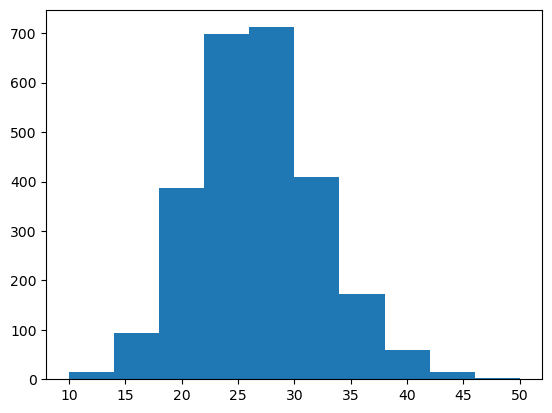

In [21]:
# ben -- is this working correctly? because by the uniform sampling arrgument (and small error due to 
# geodesic approx) we should have all the points seen approximately equally

# this is basically a draw from Multinomial(n, 1 / level4.shape[0], ...)
print('Proper mean:', n / level4.shape[0])
print('Proper std:', np.sqrt(n * (1 / level4.shape[0]) * (1 - (1 / level4.shape[0])))) # looks good enough :)
plt.hist(data_sphere_denominator[0,:])

In [22]:
data_sphere = data_sphere_numerator / data_sphere_denominator
data_sphere[0].shape # good

torch.Size([2562])

In [31]:
model = DPAGraph()
optimizer = Adam(model.parameters(), lr = 0.001)

for epoch in range(200):
    
    optimizer.zero_grad()
    Lk = [0. for _ in range(13, 16)]
        
    for i, k in enumerate(range(13, 16)):
        
        for n in range(50): # this was 100 before
            
            x = data_sphere[n].reshape(-1, 1)

            x1, x2 = model(x, k)
            Lk[i] = Lk[i] + torch.mean((x - x1)**2) + torch.mean((x - x2)**2) - torch.mean((x1 - x2)**2)

        print('=== Epoch', epoch, '| k =', k,'===')
            
    Lk = torch.stack([l / (2 * (data.shape[0])) for l in Lk])
    Lk = torch.mean(Lk)

    Lk.backward()
    optimizer.step()
    
    print('=== Epoch', epoch, '| Loss:', Lk.item(), '===')


=== Epoch 0 | k = 13 ===
=== Epoch 0 | k = 14 ===
=== Epoch 0 | k = 15 ===
=== Epoch 0 | Loss: 1.0011558644770788 ===
=== Epoch 1 | k = 13 ===
=== Epoch 1 | k = 14 ===
=== Epoch 1 | k = 15 ===
=== Epoch 1 | Loss: 0.9905121746130909 ===
=== Epoch 2 | k = 13 ===
=== Epoch 2 | k = 14 ===
=== Epoch 2 | k = 15 ===
=== Epoch 2 | Loss: 0.9805494560247358 ===
=== Epoch 3 | k = 13 ===
=== Epoch 3 | k = 14 ===
=== Epoch 3 | k = 15 ===
=== Epoch 3 | Loss: 0.9712034178887453 ===
=== Epoch 4 | k = 13 ===
=== Epoch 4 | k = 14 ===
=== Epoch 4 | k = 15 ===
=== Epoch 4 | Loss: 0.9621473190470494 ===
=== Epoch 5 | k = 13 ===
=== Epoch 5 | k = 14 ===
=== Epoch 5 | k = 15 ===
=== Epoch 5 | Loss: 0.9535383449271412 ===
=== Epoch 6 | k = 13 ===
=== Epoch 6 | k = 14 ===
=== Epoch 6 | k = 15 ===
=== Epoch 6 | Loss: 0.9450938541432133 ===
=== Epoch 7 | k = 13 ===
=== Epoch 7 | k = 14 ===
=== Epoch 7 | k = 15 ===
=== Epoch 7 | Loss: 0.9368567013499001 ===
=== Epoch 8 | k = 13 ===
=== Epoch 8 | k = 14 ===
=== Ep

## look at predictions

In [79]:
x = data_sphere[0].reshape(-1, 1)
x1, x2 = model(x, 10)

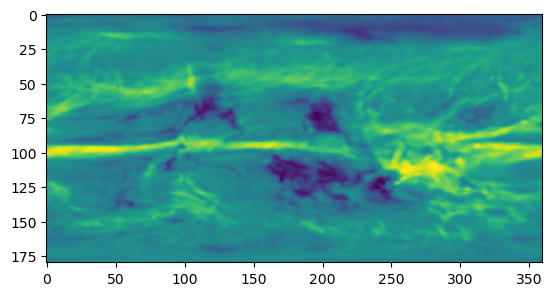

In [80]:
plt.imshow(data[0])

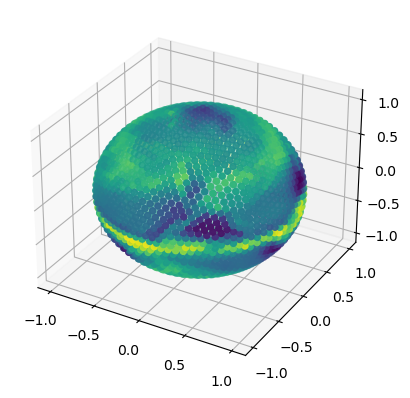

In [81]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(level4[:,0], level4[:,1], level4[:,2], c = data_sphere[-1])

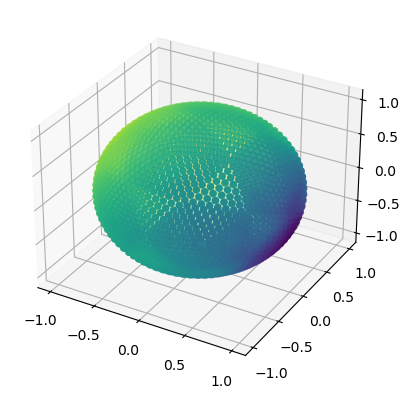

In [82]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(level4[:,0], level4[:,1], level4[:,2], c = x1.detach())

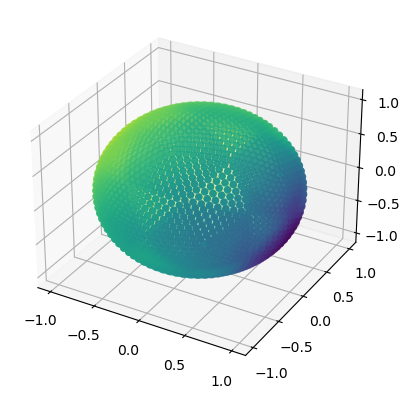

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(level4[:,0], level4[:,1], level4[:,2], c = x2.detach())

## qq plot and distribution

In [84]:
data[0].shape[0] * data[0].shape[1], level4.shape[0], 64800 * 4 # this is much smaller :(

(64800, 2562, 259200)

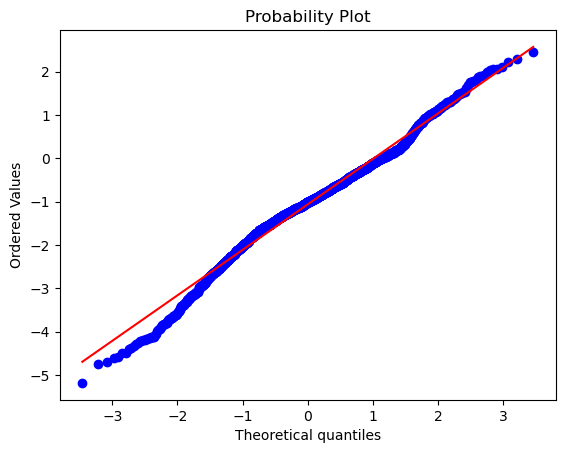

In [85]:
#stats.probplot((x1 - x).detach()[:,0], dist="norm", plot=pylab)
stats.probplot((x2 - x).detach()[:,0], dist="norm", plot=pylab)
pylab.show()

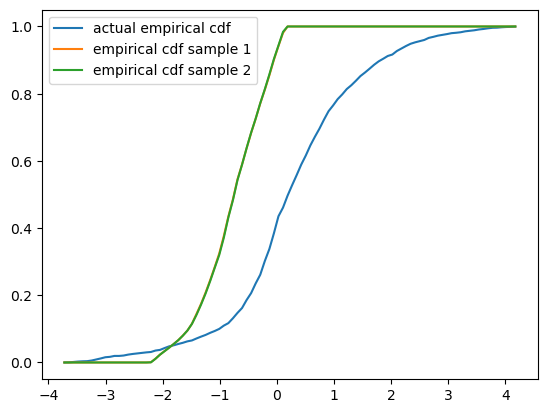

In [86]:
x_values = torch.linspace(x.min(), x.max(), 100)

plt.plot(x_values, [torch.mean(1. * (x < xi)) for xi in x_values], label = 'actual empirical cdf')
plt.plot(x_values, [torch.mean(1. * (x1 < xi)) for xi in x_values], label = 'empirical cdf sample 1')
plt.plot(x_values, [torch.mean(1. * (x2 < xi)) for xi in x_values], label = 'empirical cdf sample 2')
plt.legend()

tensor(4.1741)